In [1]:
from mind_the_gaps.lightcurves import GappyLightcurve
from mind_the_gaps.gpmodelling import GPModelling
from mind_the_gaps.models.psd_models import BendingPowerlaw, Lorentzian, SHO, Matern32, Jitter
from mind_the_gaps.models.celerite_models import Lorentzian as Lor
from mind_the_gaps.models.celerite_models import DampedRandomWalk
from mind_the_gaps.simulator import Simulator
import numpy as np
import matplotlib.pyplot as plt
import celerite, corner
from scipy.stats import percentileofscore

cpus = 15 # set the number of cores for parallelization
np.random.seed(10)

## Case of No period

# Define parameters for lightcurve simulation

In [20]:
times  = np.arange(0, 1000)
dt = np.diff(times)[0]

mean = 100

#A = (mean * 0.1) ** 2 # variance of the lorentzian
#Q = 80
variance_drw = (mean * 0.1) ** 2  # variance of the DRW (bending powerlaw)
w_bend = 2 * np.pi / 20 # angular frequency of the DRW or Bending Powerlaw

# define the PSD model
psd_model = BendingPowerlaw(variance_drw, w_bend) 

# Simulate lightcurve

Simulator will use TK95 algorithm with Gaussian pdf


Text(0, 0.5, 'Rates (ct/s)')

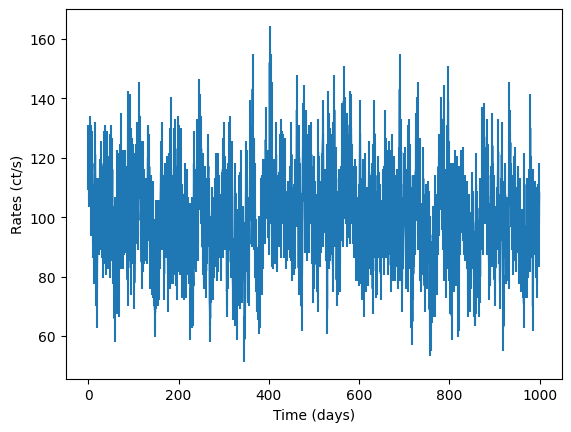

In [11]:
# create simulator object
simulator = Simulator(psd_model, times, np.ones(len(times)) * dt, mean, pdf="Gaussian")
# simulate noiseless count rates from the PSD, make the initial lightcurve 2 times as long as the original times
countrates = simulator.generate_lightcurve(extension_factor = 2)
# add (Poisson) noise
noisy_countrates, dy = simulator.add_noise(countrates)

input_lc = GappyLightcurve(times, noisy_countrates, dy, exposures=dt)

fig = plt.figure()
plt.errorbar(times, noisy_countrates, yerr=dy)
plt.xlabel("Time (days)")
plt.ylabel("Rates (ct/s)")

# Define null hypothesis

Deriving posteriors for null model


  7%|███████████▊                                                                                                                                                            | 3500/50000 [00:19<04:23, 176.60it/s]


Convergence reached after 3500 samples!


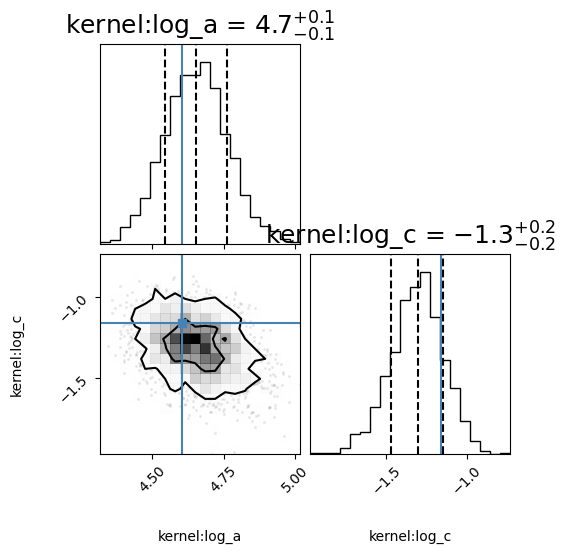

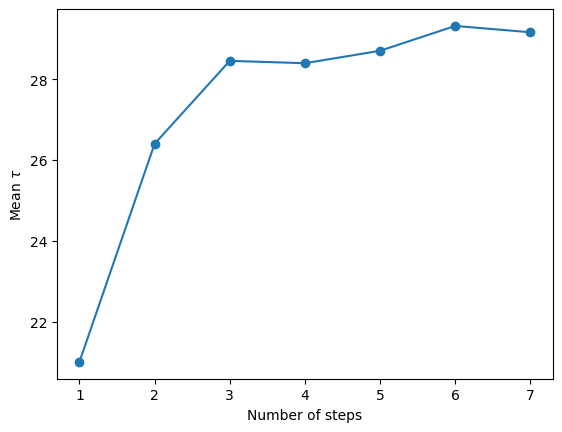

In [21]:
# null 
bounds_drw = dict(log_a=(-10, 50), log_c=(-10, 10))
# you can use RealTerm from celerite or DampedRandomWalk from models.celerite_models
null_kernel = celerite.terms.RealTerm(log_a=np.log(variance_drw), log_c=np.log(w_bend), bounds=bounds_drw)
null_model = GPModelling(input_lc, null_kernel)
print("Deriving posteriors for null model")
null_model.derive_posteriors(max_steps=50000, fit=True, cores=cpus)

corner_fig = corner.corner(null_model.mcmc_samples, labels=null_model.gp.get_parameter_names(), title_fmt='.1f',
                            quantiles=[0.16, 0.5, 0.84], show_titles=True, truths=[np.log(variance_drw), np.log(w_bend)],
                            title_kwargs={"fontsize": 18}, max_n_ticks=3, labelpad=0.08,
                            levels=(1 - np.exp(-0.5), 1 - np.exp(-0.5 * 2 ** 2))) # plots 1 and 2 sigma levels

autocorr = null_model.autocorr
fig = plt.figure()
n = np.arange(1, len(autocorr) + 1)
plt.plot(n, autocorr, "-o")
plt.ylabel("Mean $\\tau$")
plt.xlabel("Number of steps")
plt.savefig("autocorr.png", dpi=100)

# Define alternative model

log variance of the QPO: 4.61, log_c: -5.54, log_d: -0.46
Deriving posteriors for alternative model


 43%|███████████████████████████████████████████████████████████████████████▊                                                                                               | 21500/50000 [02:39<03:32, 134.42it/s]


Convergence reached after 21500 samples!


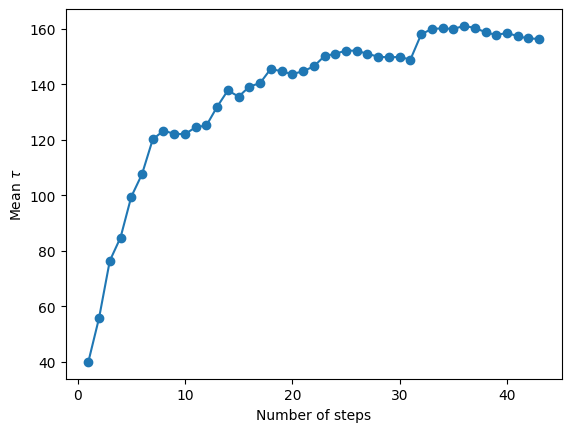

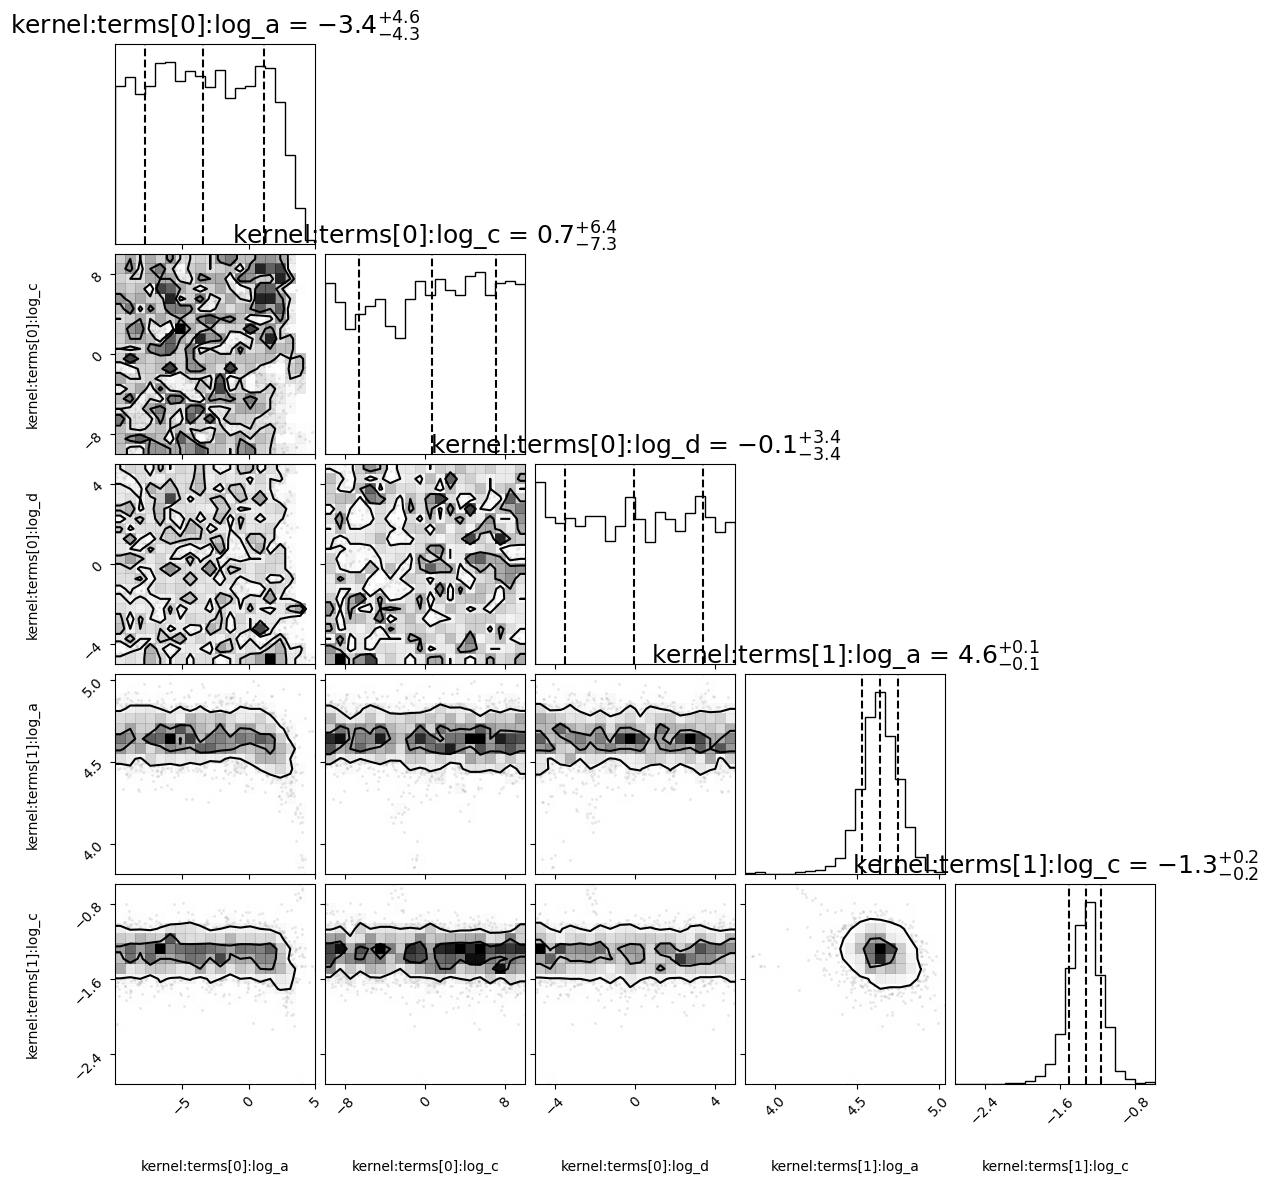

In [22]:
P = 10 # period of the QPO
w = 2 * np.pi / P
# Define starting parameters
log_variance_qpo = np.log(variance_drw)
Q = 80 # coherence
log_c = np.log(0.5 * w/Q)
log_d = np.log(w)
print(f"log variance of the QPO: {log_variance_qpo:.2f}, log_c: {log_c:.2f}, log omega: {log_d:.2f}")

bounds_qpo = dict(log_a=(-10, 50), log_c=(-10, 10), log_d=(-5, 5))
# You can also use Lorentzian from models.celerite_models (which is defined in terms of variance, Q and omega)
alternative_kernel = celerite.terms.ComplexTerm(log_a=log_variance_qpo, log_c=log_c, log_d=log_d, bounds=bounds_qpo) \
     + celerite.terms.RealTerm(log_a=np.log(variance_drw), log_c=np.log(w_bend), bounds=bounds_drw)

alternative_model = GPModelling(input_lc, alternative_kernel)
print("Deriving posteriors for alternative model")
alternative_model.derive_posteriors(max_steps=50000, fit=True, cores=cpus)

autocorr = alternative_model.autocorr
fig = plt.figure()
n = np.arange(1, len(autocorr) + 1)
plt.plot(n, autocorr, "-o")
plt.ylabel("Mean $\\tau$")
plt.xlabel("Number of steps")
plt.savefig("autocorr.png", dpi=100)

corner_fig = corner.corner(alternative_model.mcmc_samples, labels=alternative_model.gp.get_parameter_names(), 
                           title_fmt='.1f',
                            quantiles=[0.16, 0.5, 0.84], show_titles=True,
                            title_kwargs={"fontsize": 18}, max_n_ticks=3, labelpad=0.08,
                            levels=(1 - np.exp(-0.5), 1 - np.exp(-0.5 * 2 ** 2))) # plots 1 and 2 sigma levels





# Generate lightcurves from null hypothesis posteriors

In [23]:
Nsims = 100 # typically 10,000
lcs = null_model.generate_from_posteriors(Nsims, cpus=cpus)
print("Done!")

Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdfSimulator wil

# Fit the lightcurves with both null and alternative models

In [24]:
likelihoods_null = []
likelihoods_alt = []

for i, lc in enumerate(lcs):
    print("Processing lightcurve %d/%d" % (i + 1, len(lcs)), end="\r")
    
    # Run a small MCMC to make sure we find the global maximum of the likelihood
    # ideally we'd probably want to run more samples
    null_modelling = GPModelling(lc, null_kernel)
    null_modelling.derive_posteriors(fit=True, cores=cpus, walkers=2 * cpus, max_steps=500, progress=False)
    likelihoods_null.append(null_modelling.max_loglikelihodd)
    alternative_modelling = GPModelling(lc, alternative_kernel)                         
    alternative_modelling.derive_posteriors(fit=True, cores=cpus, walkers=2 * cpus, max_steps=500, 
                                            progress=False)
    likelihoods_alt.append(alternative_modelling.max_loglikelihodd)
    
                                                                              
print("\nDone!")

Processing lightcurve 100/100
Done!


# Calculate T_LRT distribution and compare with the observed value

[ 4.25309529  8.54586582  6.20846464  7.15759498  5.96943826 15.2806907
  1.65121001  2.30993382  1.00935578  3.34306038  4.54545379  5.70500627
  8.00761691  2.47604514  7.8878352   4.44006592  2.39614485  7.82143716
  5.957157    3.79060595  5.35154771  4.15007464  3.2449806   6.67106241
  4.23508504  2.8186518   2.09659814  0.7336961   6.35188767  2.81870568
  6.02930267  6.39116501  2.13838521 10.20917945  3.55411534 10.26593854
  1.69037772  5.14301796  6.54701117  4.44792742  7.46741189  2.99207077
  2.95485459 12.75806952  2.83829659  7.90987161  2.22428328  3.26169585
  5.84297906  0.91393725  8.81064544  1.97247044  6.57655013  4.53568093
  5.45205793  5.74416143  4.26292423  4.35683755  5.14862904  3.85960338
  7.49132562  5.24306809  6.77385784  7.23067811  4.7739025   3.12911211
  2.82830689  6.62750733 12.12669913  1.55160588  4.02117487 10.22254736
 11.66674464  6.24124314  2.70873513  1.81378758  4.75160147  4.03954858
  5.41105619  2.71994274  4.39423257  5.3937513   7.

Text(0.5, 0, '$T_\\mathrm{LRT}$')

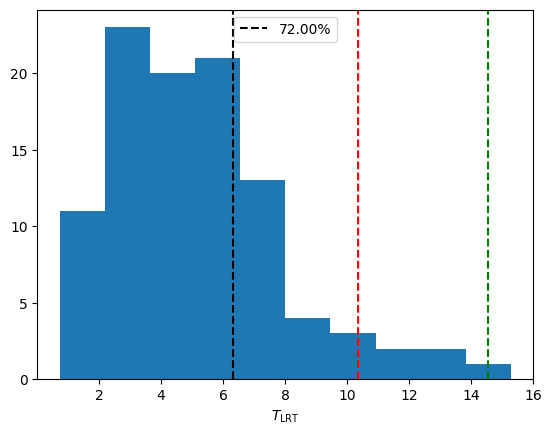

In [25]:
plt.figure()
T_dist = -2 * (np.array(likelihoods_null) - np.array(likelihoods_alt))
print(T_dist)
plt.hist(T_dist, bins=10)
T_obs = -2 * (null_model.max_loglikehood - alternative_model.max_loglikehood)
print("Observed LRT_stat: %.3f" % T_obs)
perc = percentileofscore(T_dist, T_obs)
print("p-value: %.4f" % (1 - perc / 100))
plt.axvline(T_obs, label="%.2f%%" % perc, ls="--", color="black")

sigmas = [95, 99.7]
colors= ["red", "green"]
for i, sigma in enumerate(sigmas):
    plt.axvline(np.percentile(T_dist, sigma), ls="--", color=colors[i])
plt.legend()
#plt.axvline(np.percentile(T_dist, 99.97), color="green")
plt.xlabel("$T_\\mathrm{LRT}$")

#plt.savefig("LRT_statistic.png", dpi=100)

We see the p-value to reject the null hypothesis is fairly low, indicating there is no signal in this data, as expected

# Case with Period

# Simulate lightcurve

In [29]:
times  = np.arange(0, 500)
dt = np.diff(times)[0]

mean = 100

P = 10 # period of the QPO
w_qpo = 2 * np.pi / P
w_bend = 2 * np.pi / 20 # angular frequency of the DRW or Bending Powerlaw
# Define starting parameters
variance_drw = (mean * 0.1) ** 2  # variance of the DRW (bending powerlaw)
variance_qpo = variance_drw # let's assume same variance for the QPO and the DRW

Q = 80 # coherence

psd_model = Lorentzian(variance_qpo, Q, w_qpo) + BendingPowerlaw(variance_drw, w_bend) 

Simulator will use TK95 algorithm with Gaussian pdf


Text(0, 0.5, 'Rates (ct/s)')

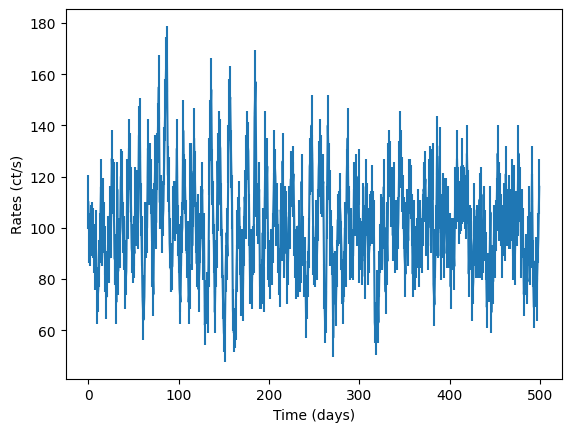

In [30]:
simulator = Simulator(psd_model, times, np.ones(len(times)) * dt, mean, pdf="Gaussian", max_iter=500)

rates = simulator.generate_lightcurve()
noisy_rates, dy = simulator.add_noise(rates)

input_lc = GappyLightcurve(times, noisy_rates, dy, exposures=dt)

fig = plt.figure()
plt.errorbar(times, noisy_rates, yerr=dy)
plt.xlabel("Time (days)")
plt.ylabel("Rates (ct/s)")

# Define null hypothesis

Deriving posteriors for null model


 15%|█████████████████████████▏                                                                                                                                              | 7500/50000 [00:36<03:29, 203.02it/s]


Convergence reached after 7500 samples!


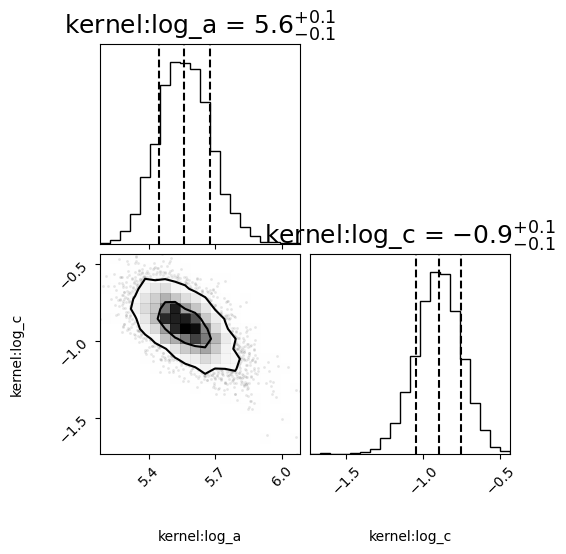

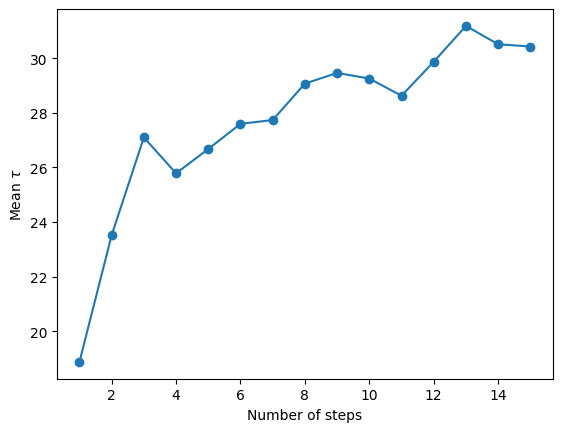

In [31]:

bounds_drw = dict(log_a=(-10, 50), log_c=(-10, 10))
# null 
null_kernel = celerite.terms.RealTerm(log_a=np.log(variance_drw), log_c=np.log(w_bend), bounds=bounds_drw)
null_model = GPModelling(input_lc, null_kernel)
print("Deriving posteriors for null model")
null_model.derive_posteriors(max_steps=50000, fit=True, cores=cpus)

corner_fig = corner.corner(null_model.mcmc_samples, labels=null_model.gp.get_parameter_names(), title_fmt='.1f',
                            quantiles=[0.16, 0.5, 0.84], show_titles=True,
                            title_kwargs={"fontsize": 18}, max_n_ticks=3, labelpad=0.08,
                            levels=(1 - np.exp(-0.5), 1 - np.exp(-0.5 * 2 ** 2))) # plots 1 and 2 sigma levels

autocorr = null_model.autocorr
fig = plt.figure()
n = np.arange(1, len(autocorr) + 1)
plt.plot(n, autocorr, "-o")
plt.ylabel("Mean $\\tau$")
plt.xlabel("Number of steps")
plt.savefig("autocorr.png", dpi=100)

# Define alternative model

Deriving posteriors for alternative model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [06:11<00:00, 134.67it/s]


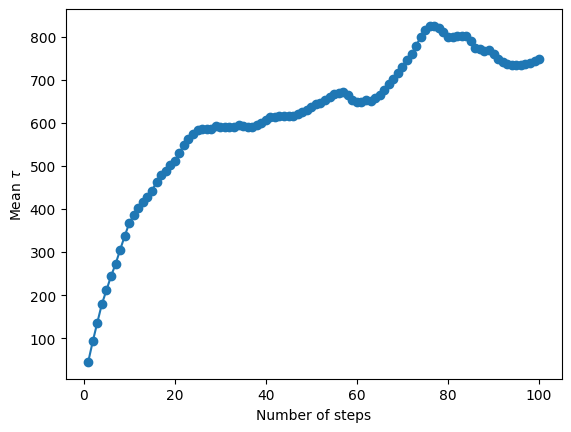

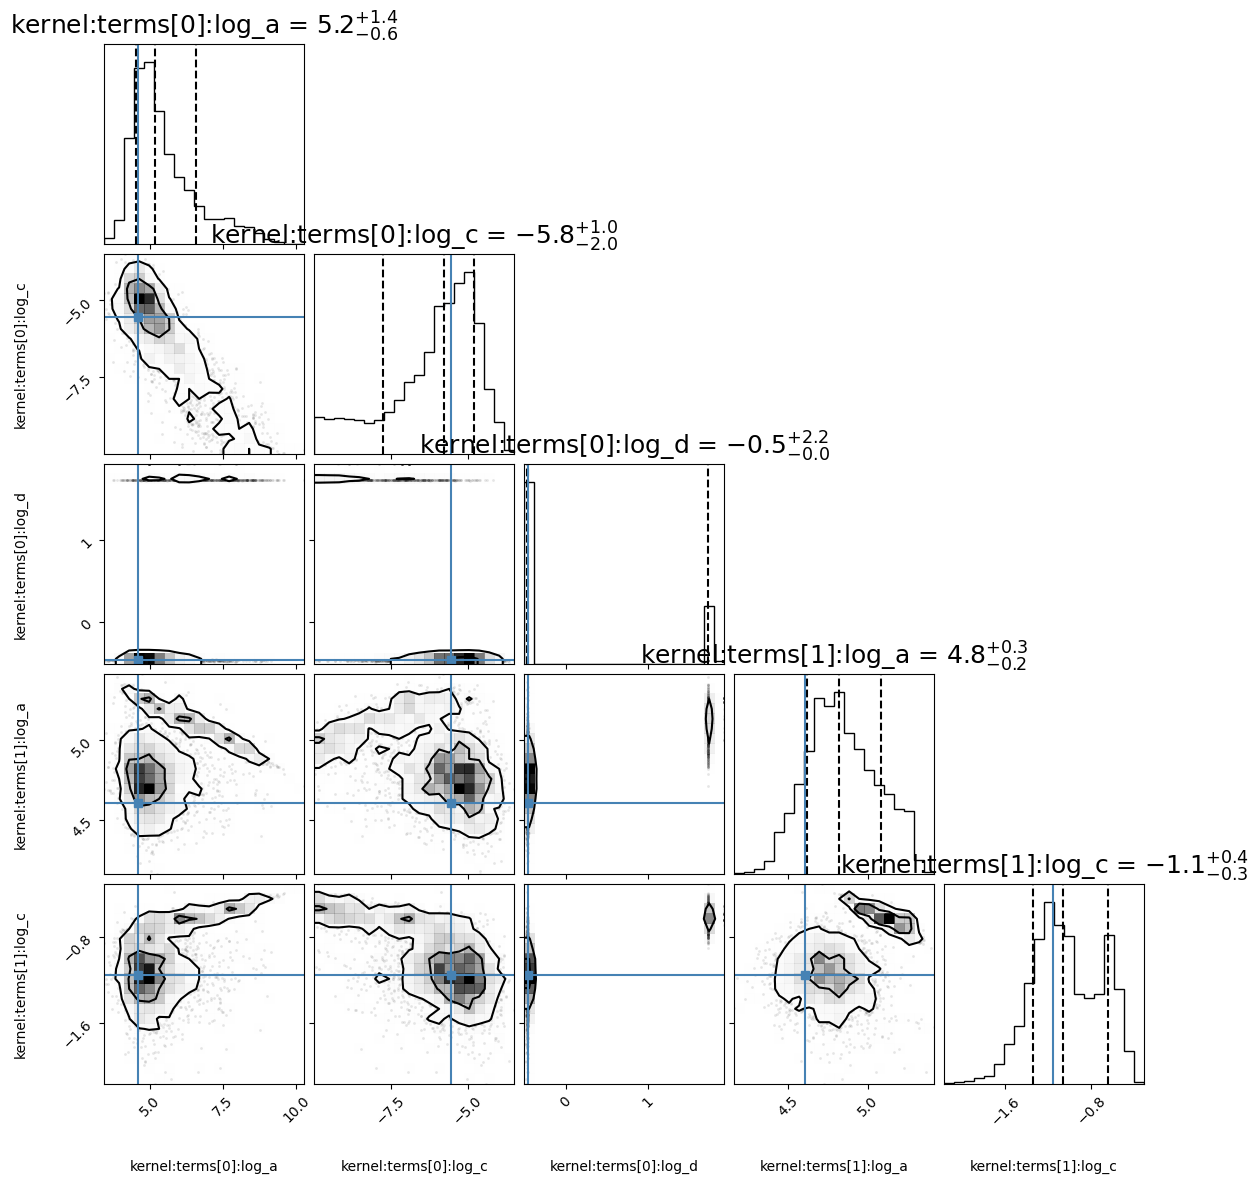

In [35]:
log_c = np.log(0.5 * w_qpo/Q)
log_d = np.log(w_qpo)
bounds_qpo = dict(log_a=(-10, 50), log_c=(-10, 10), log_d=(-5, 5))
# again you may use the Lorentzian from models.celerite_models
alternative_kernel = celerite.terms.ComplexTerm(log_a=np.log(variance_qpo), log_c=log_c, 
                                                log_d=np.log(w_bend), bounds=bounds_qpo) \
     + celerite.terms.RealTerm(log_a=np.log(variance_drw), log_c=np.log(w_bend), bounds=bounds_bend)


alternative_model = GPModelling(input_lc, alternative_kernel)
print("Deriving posteriors for alternative model")
alternative_model.derive_posteriors(max_steps=50000, fit=True, cores=cpus)

autocorr = alternative_model.autocorr
fig = plt.figure()
n = np.arange(1, len(autocorr) + 1)
plt.plot(n, autocorr, "-o")
plt.ylabel("Mean $\\tau$")
plt.xlabel("Number of steps")
plt.savefig("autocorr.png", dpi=100)

corner_fig = corner.corner(alternative_model.mcmc_samples, labels=alternative_model.gp.get_parameter_names(), title_fmt='.1f',
                            quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                           truths=[np.log(variance_qpo), log_c, log_d, np.log(variance_drw), np.log(w_bend)],
                            title_kwargs={"fontsize": 18}, max_n_ticks=3, labelpad=0.08,
                            levels=(1 - np.exp(-0.5), 1 - np.exp(-0.5 * 2 ** 2))) # plots 1 and 2 sigma levels





# Generate lightcurves with null hypothesis posteriors

In [36]:
Nsims = 100 # typically 10,000
lcs = null_model.generate_from_posteriors(Nsims, cpus=cpus)
print("Done!")

Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdfSimulator will use TK95 algorithm with Gaussian pdf

Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator will use TK95 algorithm with Gaussian pdf
Simulator wi

# Fit the lightcurves with both null and alternative models

In [39]:
likelihoods_null = []
likelihoods_alt = []

for i, lc in enumerate(lcs):
    print("Processing lightcurve %d/%d" % (i + 1, len(lcs)), end="\r")
    #fig = plt.figure()
    #plt.errorbar(lc.times, lc.y, lc.dy)
    #plt.xlabel("Time (days)")
    #plt.ylabel("Rate (ct/s)")
    #plt.savefig("%d.png" % i, dpi=100)
    
    # Run a small MCMC to make sure we find the global maximum of the likelihood
    # ideally we'd probably want to run more samples
    null_modelling = GPModelling(lc, null_kernel)
    null_modelling.derive_posteriors(fit=True, cores=cpus, walkers=2 * cpus, max_steps=500, progress=False)
    likelihoods_null.append(null_modelling.max_loglikelihood)
    alternative_modelling = GPModelling(lc, alternative_kernel)                         
    alternative_modelling.derive_posteriors(fit=True, cores=cpus, walkers=2 * cpus, max_steps=500, 
                                            progress=False)
    likelihoods_alt.append(alternative_modelling.max_loglikelihood)
    
                                                                              
print("\nDone!")

Processing lightcurve 100/100
Done!


# Calculate T_LRT distribution and compare with the observed value

[ 2.28028354  2.53048111  3.78390512  3.33686213  3.46649275  1.67408528
  8.70924167  6.73169131  3.04561526  2.21503773  4.12500058  3.75825137
  6.1415742   2.8934624   5.89591985  5.52500467  4.89106421  6.78805598
  4.60297473  8.00219309  6.44223465  6.23089348  2.79846113  4.86108576
  2.31427124  1.77189641  8.0437856   4.86292335  4.37173632  8.11363612
  1.13663662  1.73564601  5.76165833  2.20589767  4.35683323  3.82221309
  2.77385953 12.03229573  6.77770467  5.54139873  7.74750261  2.03847024
  5.46296326  2.67603268  6.5646448   3.04889645  2.59092229  5.08542281
  2.04691286  3.90426884  2.02031522  1.78532962  5.63264511  6.16563145
  1.27473437  3.07511188  1.77047338  0.55004748  7.16412231  6.55563151
  1.99849809  8.01820618  5.09961691  5.04185878  6.59897196  2.48901793
  2.06647851  2.5211985   4.86893098  3.96376611  4.85941204  0.84278053
  1.91531099  2.10992591  1.72190365  3.58043786 12.98372957  0.7672661
  1.66924977  6.64983386  4.06888641  2.74893742  2.

Text(0.5, 0, '$T_\\mathrm{LRT}$')

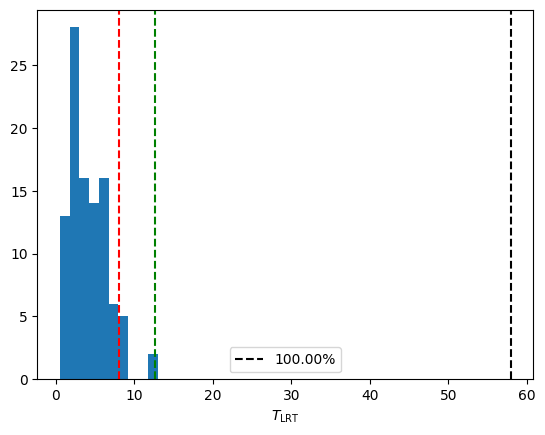

In [40]:
plt.figure()
T_dist = -2 * (np.array(likelihoods_null) - np.array(likelihoods_alt))
print(T_dist)
plt.hist(T_dist, bins=10)
T_obs = -2 * (null_model.max_loglikelihood - alternative_model.max_loglikelihood)
print("Observed LRT_stat: %.3f" % T_obs)
perc = percentileofscore(T_dist, T_obs)
print("p-value: %.4f" % (1 - perc / 100))
plt.axvline(T_obs, label="%.2f%%" % perc, ls="--", color="black")

sigmas = [95, 99.7]
colors= ["red", "green"]
for i, sigma in enumerate(sigmas):
    plt.axvline(np.percentile(T_dist, sigma), ls="--", color=colors[i])
plt.legend()
#plt.axvline(np.percentile(T_dist, 99.97), color="green")
plt.xlabel("$T_\\mathrm{LRT}$")

#plt.savefig("LRT_statistic.png", dpi=100)